# Impute Missing data using STL and linear interpolation
Conda environment: `time-series`  
18 Feb 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
df = pd.read_csv("../datasets/example_retail_sales_with_missing_data.csv",
                parse_dates= ["ds"],
                index_col=["ds"])

df

,y
ds,
1992-01-01,"146,376.0000"
1992-02-01,"147,079.0000"
1992-03-01,"159,336.0000"
1992-04-01,"163,669.0000"
1992-05-01,"170,068.0000"
...,...
2004-12-01,"387,155.0000"
2005-01-01,"293,261.0000"
2005-02-01,"295,062.0000"


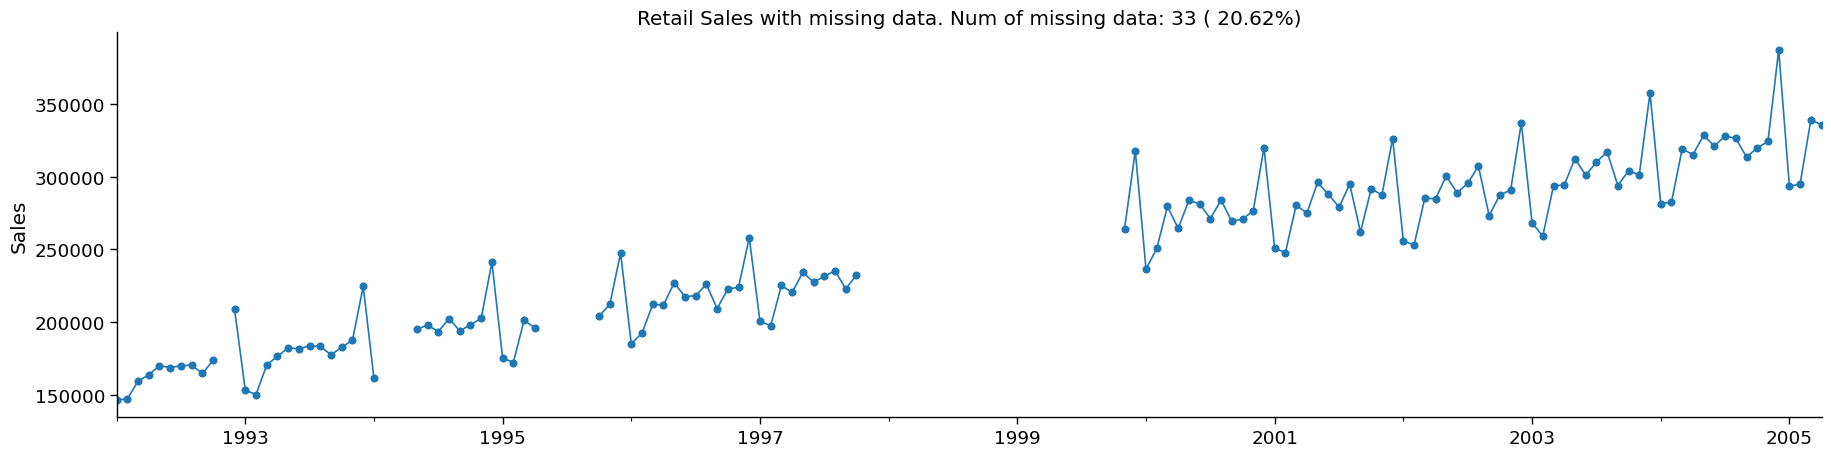

In [4]:
# Plot vars
n_missing = df["y"].isnull().sum()

# Plot
df.plot(marker="o", legend=False)

plt.title(f"Retail Sales with missing data. Num of missing data: {n_missing} ({n_missing/len(df): .2%})")
plt.ylabel("Sales")
plt.xlabel("")
plt.show()

## 2) STL decomposition + Linear interpolation

### 2.1) Linear interpolation

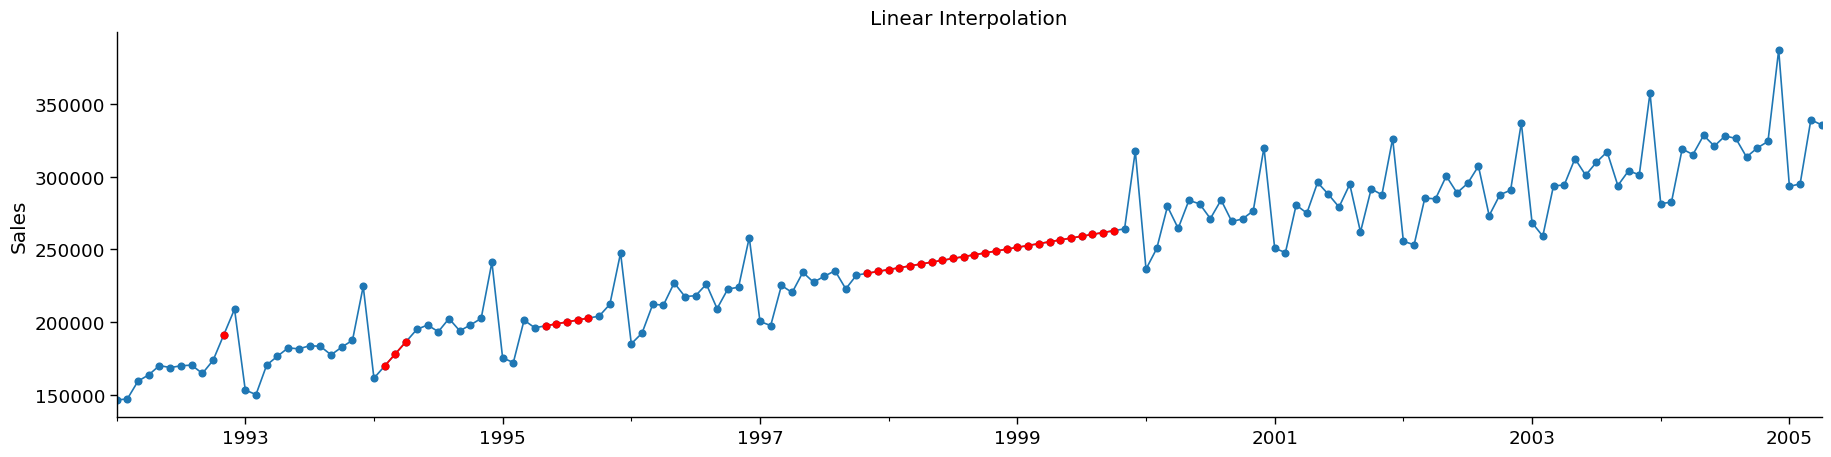

In [5]:
# You can also use method=time
df_imputed = df.interpolate(method="linear")

ax = df_imputed.plot(marker="o",legend=False)
df_imputed[df.isnull()].plot(ax=ax, legend=False, color="red", marker="o")

ax.set_title("Linear Interpolation")
ax.set_xlabel("")
ax.set_ylabel("Sales")

plt.show()

### 2.2) STL decomposition + Linear interpolation
STL can not handle missing data, so we implement a linear interpolation.  
`STL parameters`:
* `period`: The periodicity of the seasonal component (*e.g.*, for yearly seasonality and monthly data, this would be 12).
* `seasonal`: Determines the window size for LOESS used when smoothing the seasonal component. Default = 7.
* `robust`: A flag to use robustness weights during regression in LOESS (if you suspect for outliers).  

**NOTE**:   
The seasonal parameter determines how much data is used to infer the seasonality at any given point.   
The large missing gap is linearly interpolated. This means that the algorithm sees a region of data with no seasonal component.   
Thus, a large seasonal parameter is set (`seasonal=31`). This works because a larger portion of the data is now used to estimate the seasonal component.

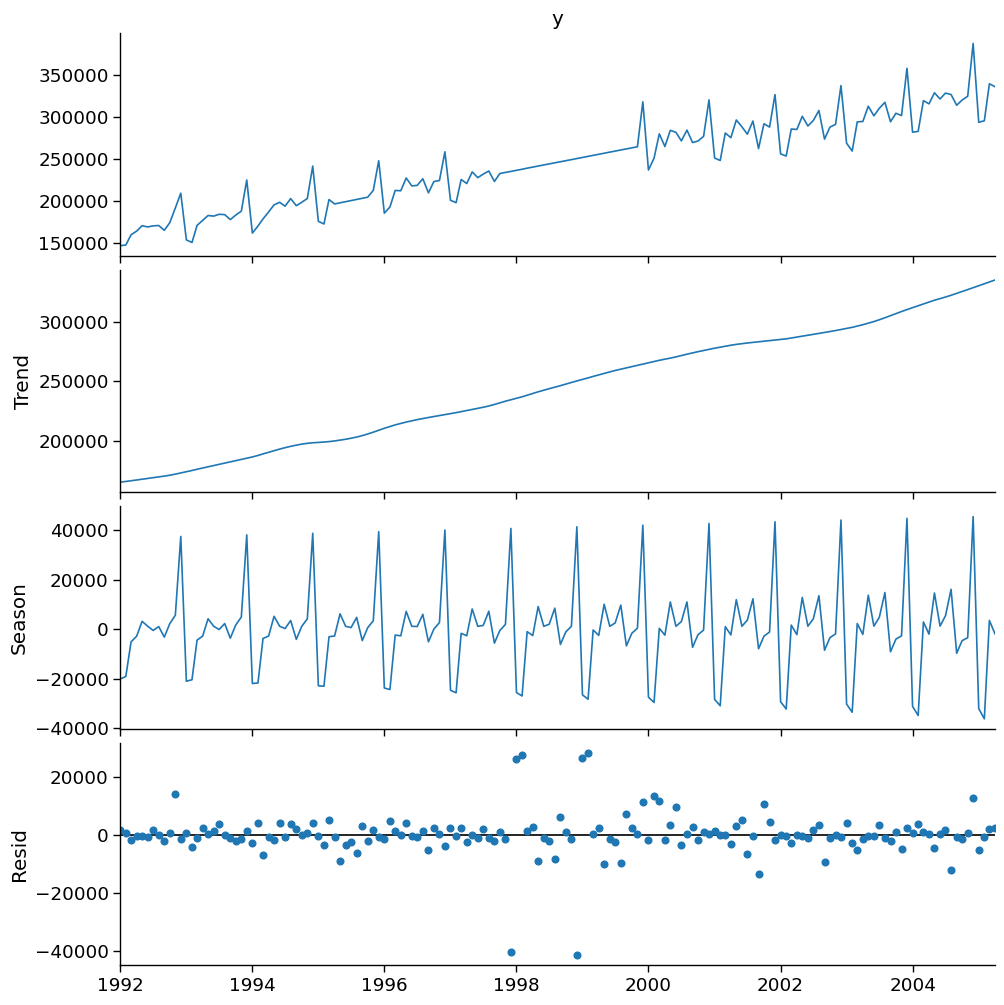

In [6]:
# squeeze: from pd.DataFrame to pd.Series
SEASONAL = 31
res = STL(df.interpolate(method="linear").squeeze(), 
            seasonal=SEASONAL, 
            robust=True)\
            .fit()

# Plot
plt.rc("figure", figsize=(10,10))
plt.rc("font", size=5)
res.plot()

plt.show()

Remember `STL` assume an `additive model`.   
We should implement a Box-Cox or log transformation to avoid this assumption (*i.e.* convert a multiplicative time-series into an additive).
* **1)** Obtain the seasonal component.
* **2)** De-seasonalise the original time series.
* **3)** Linear interpolation on the de-seasonalised data.
* **4)** Add the seasonal component back to the imputed de-seasonalised data.

In [7]:
# 1) 
seasonal_component = res.seasonal
# 2)
df_deseasonalised = df["y"] - seasonal_component
# 3) 
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")
# 4) 
final_df = df_deseasonalised_imputed + seasonal_component
final_df = final_df.to_frame().rename(columns={0: "y"})

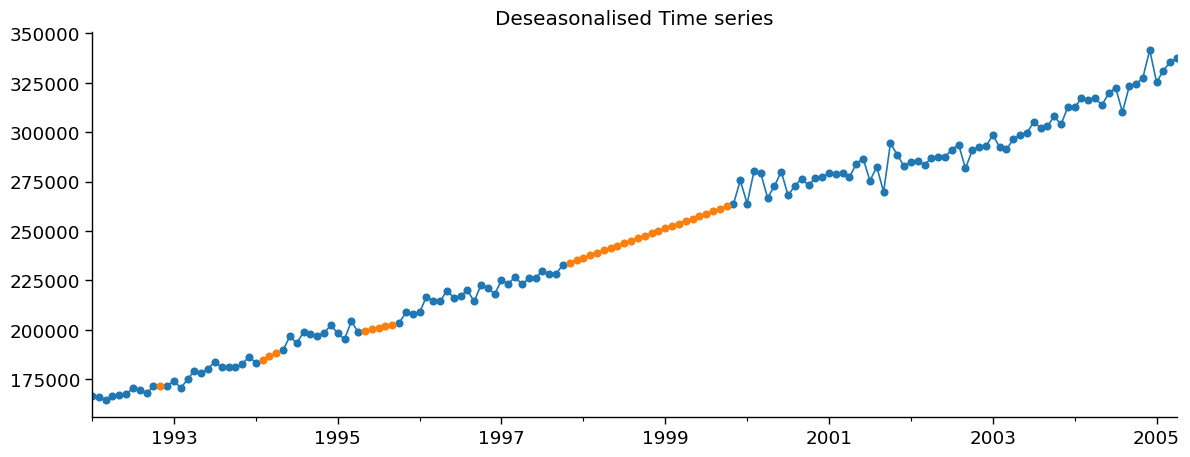

In [8]:
ax = df_deseasonalised.plot(figsize=(14,5), legend=False, marker="o")
df_deseasonalised_imputed.to_frame().rename(columns={0: "y"})[df.isnull()].plot(ax= ax, legend=False, marker="o")

ax.set_title("Deseasonalised Time series")
ax.set_xlabel("")

plt.show()

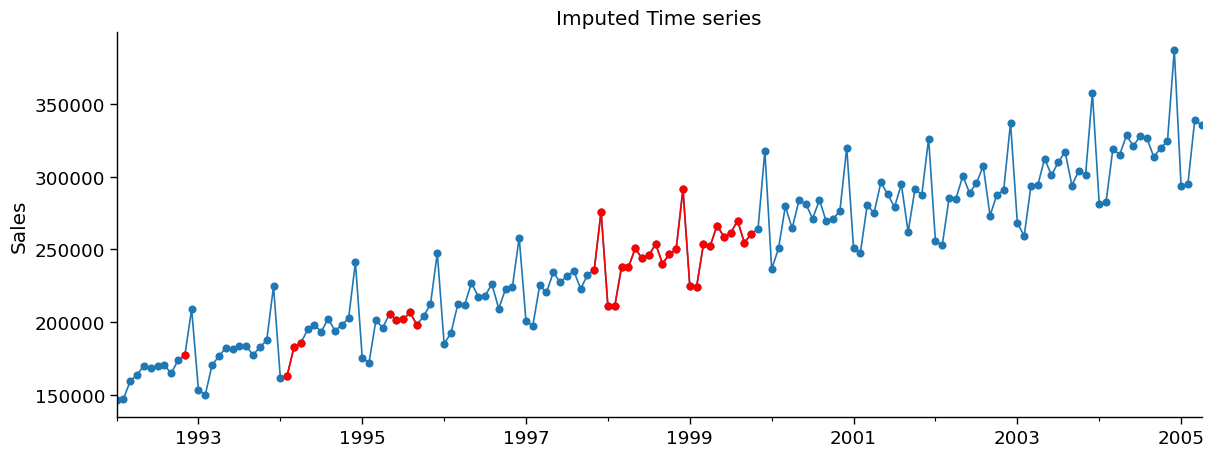

In [9]:
ax = final_df.plot(legend=False, figsize=(14,5), marker="o")
final_df[df.isnull()].plot(ax=ax, color="red", legend=False, marker="o")

ax.set_title("Imputed Time series")
ax.set_xlabel("")
ax.set_ylabel("Sales")
plt.show()